# How to use lightkurve to find pixels from neighbouring campaigns

Sometimes you may be concerned that a signal you have found is due to a bad pixel.

In [1]:
import K2fov
import lightkurve as lk
from astropy.table import Table, vstack
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(lk.MPLSTYLE)

In [24]:
tpf = lk.search_targetpixelfile('K2-18').download()

In [25]:
channel, column, row = tpf.channel, tpf.column, tpf.row

In [26]:
channel, column, row, tpf.campaign

(72, 655, 934, 1)

In [27]:
result = None
for campaign in np.arange(20):
    f = K2fov.getKeplerFov(campaign)
    ra, dec = f.getRaDecForChannelColRow(channel, column, row)
    sr = lk.search_targetpixelfile('{}, {}'.format(ra, dec), mission='K2', campaign=campaign, radius=100)
    if len(sr) != 0:
        if result is None:
            result = sr.table
        else:
            result = vstack([result, sr.table])

No data found for target "94.51453384338271, 26.896983067852652".
ERROR:lightkurve.search:No data found for target "94.51453384338271, 26.896983067852652".
No data found for target "243.2343649937126, -16.733420674307173".
ERROR:lightkurve.search:No data found for target "243.2343649937126, -16.733420674307173".
No data found for target "54.049037423922584, 22.902178132621188".
ERROR:lightkurve.search:No data found for target "54.049037423922584, 22.902178132621188".
No data found for target "203.28748572116018, -5.161181531216283".
ERROR:lightkurve.search:No data found for target "203.28748572116018, -5.161181531216283".
No data found for target "283.3658649762395, -18.59388536128617".
ERROR:lightkurve.search:No data found for target "283.3658649762395, -18.59388536128617".
No data found for target "274.44406805729176, -26.897942105705035".
ERROR:lightkurve.search:No data found for target "274.44406805729176, -26.897942105705035".
No data found for target "185.42269526416408, 2.155467

In [28]:
sr = lk.search.SearchResult(result)

In [29]:
tpfs = sr.download_all()

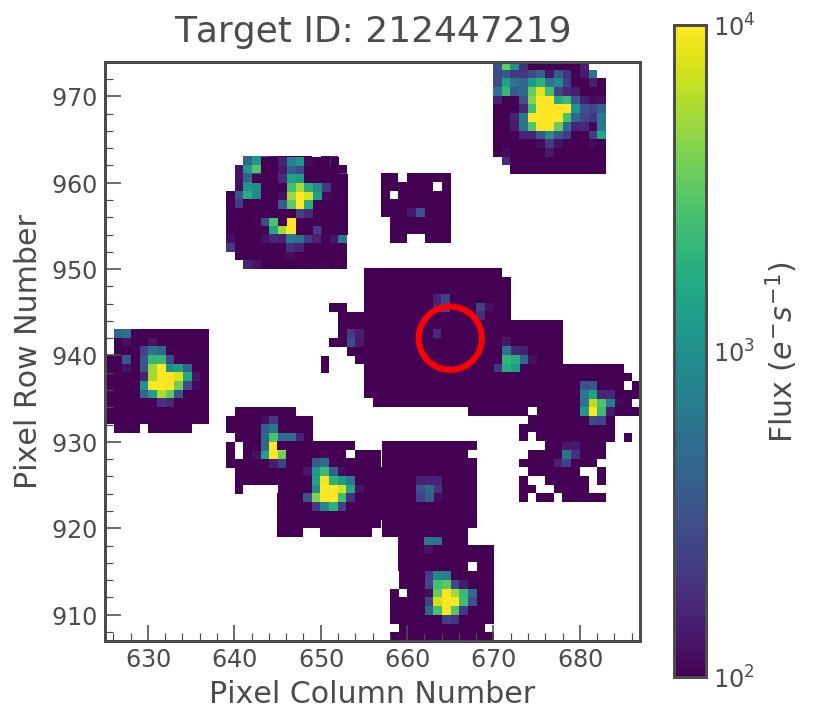

In [30]:
fig, ax = plt.subplots(figsize=(6, 6))
xlims, ylims = [2e3, -1], [2e3, -1]
for idx, tpf1 in enumerate(tpfs):
    if idx == 0 :
        im = tpf1.plot(ax=ax, scale='log', vmin=1e2, vmax=1e4)
    else:
        im = tpf1.plot(ax=ax, show_colorbar=False, scale='log', vmin=1e2, vmax=1e4)
    xlims[0] = np.min([xlims[0], ax.get_xlim()[0]])
    xlims[1] = np.max([xlims[1], ax.get_xlim()[1]])
    ylims[0] = np.min([ylims[0], ax.get_ylim()[0]])
    ylims[1] = np.max([ylims[1], ax.get_ylim()[1]])
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.scatter(tpf.column + tpf.shape[1]//2 + 2, tpf.row + tpf.shape[2]//2, s=1000, facecolor='None', edgecolor='r', lw=3)

In [31]:
c, r = np.meshgrid(tpf.column + np.arange(tpf.shape[2]), tpf.row + np.arange(tpf.shape[1]))
overlap = []
for tpf1 in tpfs:
    c1, r1 = np.meshgrid(tpf1.column + np.arange(tpf1.shape[2]), tpf1.row + np.arange(tpf1.shape[1]))
    overlap.append((np.in1d(c.ravel(), c1.ravel()) & np.in1d(r.ravel(), r1.ravel())).any())
overlap = np.asarray(overlap)

/Users/ch/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/Users/ch/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/Users/ch/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/Users/ch/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Text(0.5,1,'Targets Telemetered From The\nSame Pixel Region')

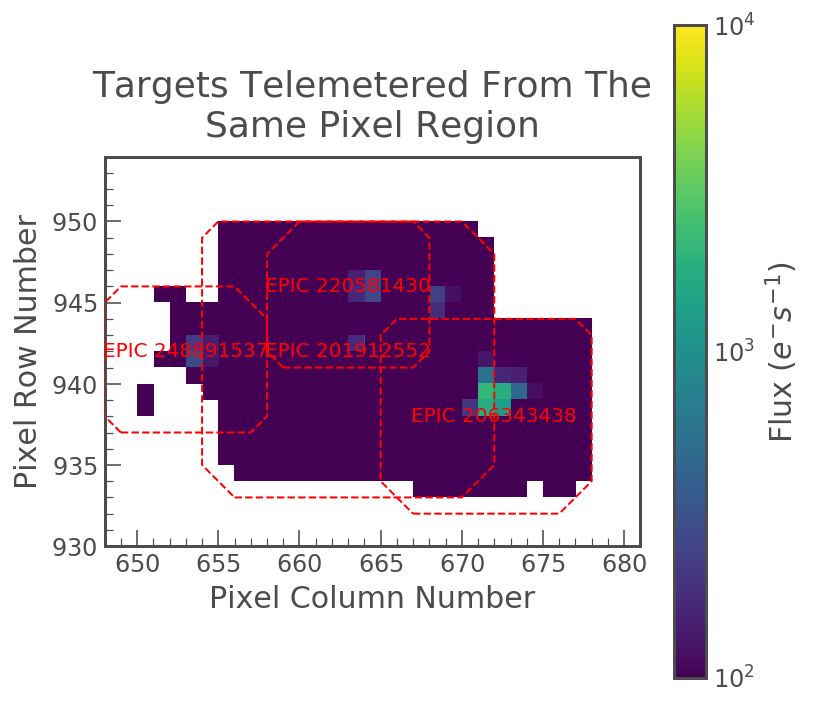

In [37]:
fig, ax = plt.subplots(figsize=(6, 6))
xlims, ylims = [2e3, -1], [2e3, -1]
for idx, o in enumerate(np.where(overlap)[0]):
    tpf1 = tpfs[o]
    thumb = np.zeros((tpf1.shape[1] + 2, tpf1.shape[2] + 2))
    thumb[1:-1, 1:-1] = np.asarray(np.isfinite(tpf1.flux[0]), int)
    c1, r1 = tpf1.column + np.arange(-1, tpf1.shape[2] + 1), tpf1.row + np.arange(-1, tpf1.shape[1] + 1)
    ax.contour(c1, r1, thumb, colors='r', levels=0, linewidths=1, zorder=10, linestyles='--')
    if idx == 0 :
        im = tpf1.plot(ax=ax, scale='log', vmin=1e2, vmax=1e4)
    else:
        im = tpf1.plot(ax=ax, show_colorbar=False, scale='log', vmin=1e2, vmax=1e4)
    
    xlims[0] = np.min([xlims[0], ax.get_xlim()[0]]) - 1
    xlims[1] = np.max([xlims[1], ax.get_xlim()[1]]) + 1
    ylims[0] = np.min([ylims[0], ax.get_ylim()[0]]) - 1
    ylims[1] = np.max([ylims[1], ax.get_ylim()[1]]) + 1
    ax.text(tpf1.column + tpf1.shape[2]//2, tpf1.row + tpf1.shape[1]//2, 'EPIC {}'.format(tpf1.targetid), color='r', ha='center', va='center')

ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_title('Targets Telemetered From The\nSame Pixel Region')

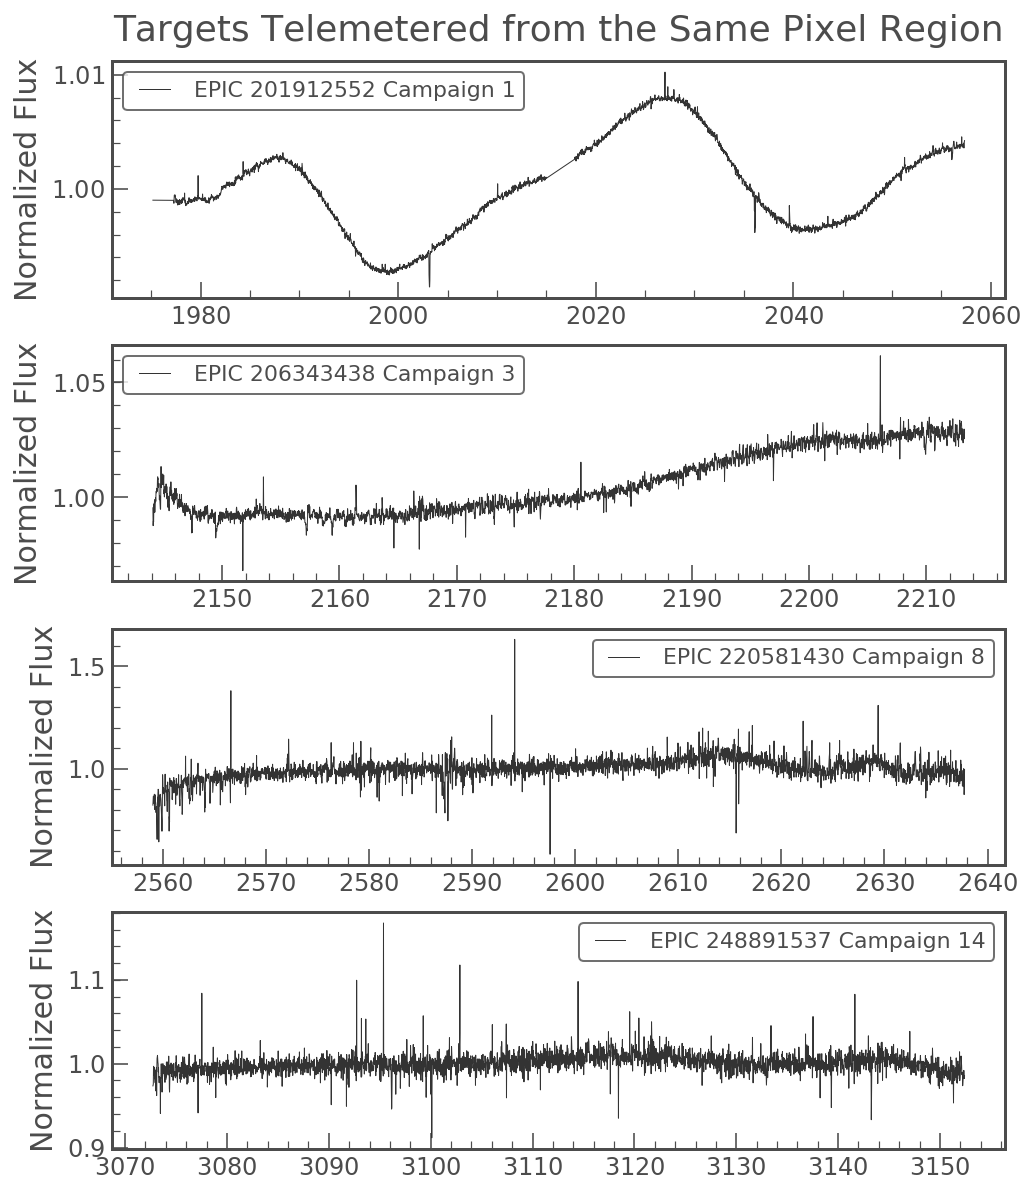

In [34]:
fig, axs = plt.subplots(overlap.sum(), figsize=(8, overlap.sum()*2.5))
for idx, o in enumerate(np.where(overlap)[0]):
    tpf1 = tpfs[o]    
    clc = tpf1.to_corrector('pld').correct()
    clc.plot(ax=axs[idx], label='EPIC {} Campaign {}'.format(tpf1.targetid, tpf1.campaign))
    if idx < overlap.sum():
        axs[idx].set_xlabel('')
    if idx == 0:
        axs[idx].set_title('Targets Telemetered from the Same Pixel Region')